In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import deepwave
import h5py
from pathlib import Path

from einops.array_api import rearrange
from soupsieve.util import lower

from utils import *
from einops import rearrange
from omegaconf import OmegaConf
from scipy.ndimage import gaussian_filter
from utils.utils_plot import plot_model,plot_shot

from utils import make_and_load_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 设置config路径

In [35]:
test_index = 0

config_path = "./config/template.yaml"
cfg = OmegaConf.load(config_path)
cfg.generate_par.type = 'UNet'
net_name = lower(cfg.generate_par.type)
cfg.generate_par.train_log_path = f"/data/yibiao/nn_loss/experiments/marmousi/log/train_{net_name}_{test_index}.hdf5"
cfg.generate_par.inversion_log_path = f"/data/yibiao/nn_loss/experiments/marmousi/log/inversion_{net_name}_{test_index}.hdf5"
cfg.generate_par.checkpoint_path = f"/data/yibiao/nn_loss/experiments/marmousi/log/model_{net_name}_{test_index}.pt"


# 可视化训练阶段损失

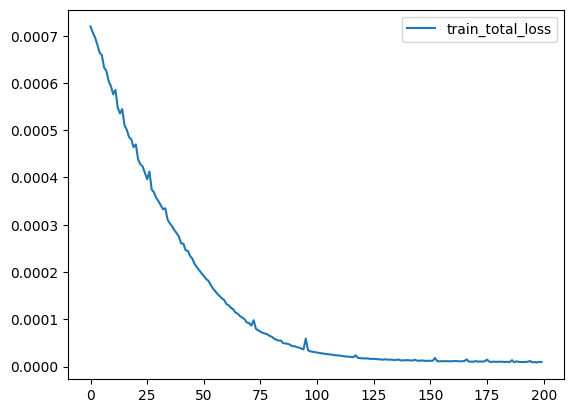

In [36]:
if cfg.generate_par.type == "FWI":
    pass
elif cfg.generate_par.type in ["UNet","CAE",]:
    train_log_path = cfg.generate_par.train_log_path
    with h5py.File(train_log_path,"r") as f:
                data = f["train_total_loss"][200:]
                plt.plot(data, label="train_total_loss")
                plt.legend()
else:
    train_log_path = cfg.generate_par.train_log_path
    with h5py.File(train_log_path,"r") as f:
        data = f["train_mse_loss"][50:]
        plt.plot(data, label="train_mse_loss")
        plt.legend()


# 可视化自编码器效果

模型已经成功加载。
0.015346844


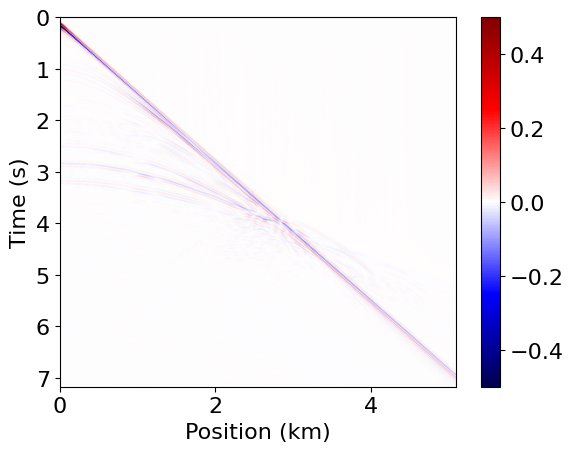

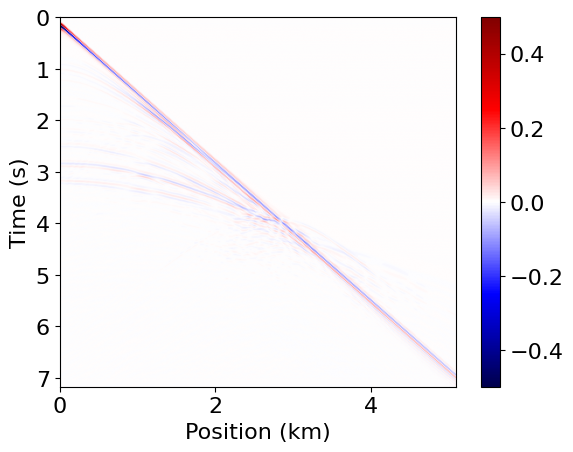

In [37]:
shot_index = 0
scale = 2

model = make_and_load_model(cfg)
model.eval()
obs_signal = np.load(cfg.generate_par.obs_signal_path)[shot_index,:,:]
obs_signal = obs_signal / np.max(np.abs(obs_signal))
input_obs_signal = rearrange(torch.from_numpy(obs_signal).float().to(device),"r t -> r 1 t")
output_obs_signal = model.forward(input_obs_signal)["re_signal"]
re_obs_signal = rearrange(output_obs_signal,"r 1 t -> r t").detach().cpu().numpy()

print(np.max(np.abs(obs_signal - re_obs_signal)))
plot_shot(obs_signal.T, cfg.forward_par.dt, cfg.forward_par.grid_spacing, title='', pclip=1.0, scale=scale)
plot_shot(re_obs_signal.T, cfg.forward_par.dt, cfg.forward_par.grid_spacing, title='', pclip=1.0, scale=scale)

# 可视化反演阶段损失

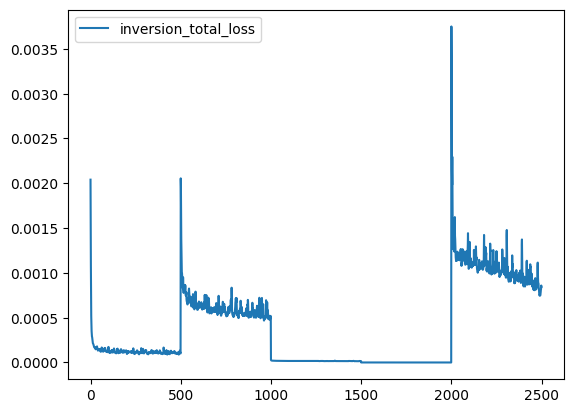

In [38]:
inversion_log_path = cfg.generate_par.inversion_log_path
with h5py.File(inversion_log_path,"r") as f:
        data = f["inversion_total_loss"][:]
        plt.plot(data, label="inversion_total_loss")
        plt.legend()


# 可视化反演结果

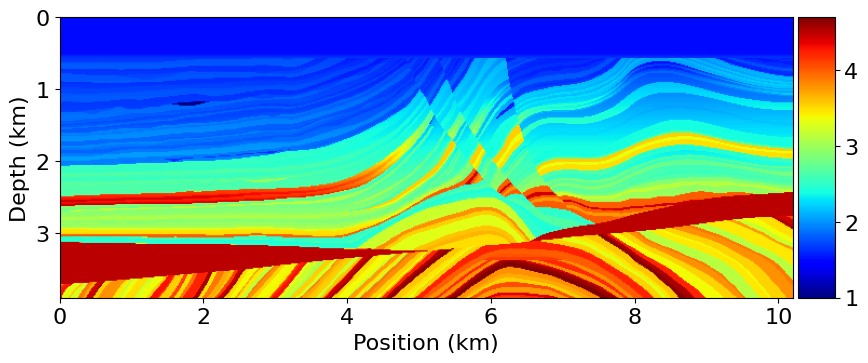

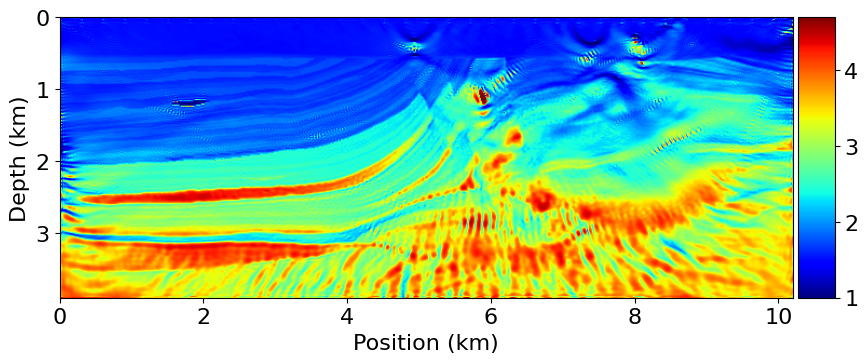

In [39]:
aspect = 1
figsize = (10,10)

vp_true = np.load(cfg.forward_par.vp_true_path)
with h5py.File(cfg.generate_par.inversion_log_path,"r") as f:
    vp_inv = f["vp_inv"][-1]

plot_model(vp_true.T, cfg.forward_par.grid_spacing, cfg.forward_par.min_vel/1000, cfg.forward_par.max_vel/1000, title='',aspect = aspect,figsize=figsize)
plot_model(vp_inv.T, cfg.forward_par.grid_spacing, cfg.forward_par.min_vel/1000, cfg.forward_par.max_vel/1000, title='',aspect = aspect,figsize=figsize)
